# Setup

In [29]:
import pandas as pd
import sqlite3
from pathlib import Path
import logging
import traceback
import seaborn as sns
from matplotlib import pyplot
import tomllib

In [30]:
def check_if_valid(config_data: dict):
    for config_key, config_val in config_data.items():
        if not isinstance(config_val, str):
            continue

        if not config_val.strip():
            raise ValueError(f'Configuration: \'{config_key}\' can\'t be empty string')

def get_sqlite_db(toml_file: str):
    config_path = Path(toml_file).resolve()

    if not config_path.is_file():
        raise FileNotFoundError(f'Database config file isn\'t found {str(config_path)}')
    

    with open(str(config_path), 'rb') as config_file:
        config_db = tomllib.load(config_file)
        check_if_valid(config_db)

        return config_db

## Sqlite Commnads

In [31]:
comd_artists_reviews = """
    SELECT
        artists.reviewid,
        artists.artist,
        reviews.title,
        reviews.url,
        reviews.score,
        reviews.best_new_music,
        reviews.author,
        reviews.author_type,
        reviews.pub_date,
        reviews.pub_weekday,
        reviews.pub_day,
        reviews.pub_month,
        reviews.pub_year
    FROM artists
    INNER JOIN reviews on reviews.reviewid = artists.reviewid
"""

comd_artists = """
    SELECT
        *
    FROM artists
"""

comd_genres_reviews = """
    SELECT
        *
    FROM genres
    INNER JOIN reviews on reviews.reviewid = genres.reviewid
"""

comd_labels_reviews = """
    SELECT
        *
    FROM labels
    INNER JOIN reviews on reviews.reviewid = labels.reviewid
"""

comd_labels = """
    SELECT
        *
    FROM labels
"""

## Sql Setup

In [32]:
class SQLITEConnection:
    def __init__(self, commd: str) -> None:
        db_config = get_sqlite_db('../db_config.toml')
        self.__db_path = str(Path('..', db_config['sqlite_db_relpath']).resolve())
        self.__commd =  commd


    def __gen_db(self) -> pd.DataFrame:
        return pd.read_sql(
            sql=self.__commd,
            con=self.__conn
        )
    
    def __enter__(self):
        self.__conn = sqlite3.connect(self.__db_path)
        self.__conn.row_factory = sqlite3.Row

        return self.__gen_db
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        if exc_traceback:
            logging.error(''.join(traceback.format_exception(exc_type, exc_value, exc_traceback)))
        self.__conn.close()
        # print('\nConnection Closed')

# Artists with High Score (Overall)

In [33]:
def get_artists_reviewed_multiple_times(df: pd.DataFrame):
    valid_df = df[df['artist'] != 'various artists']
    valid_df = valid_df['artist'].value_counts().sort_values(ascending=False)
    valid_df = valid_df[valid_df > 20]

    # print(valid_df)
    
    return df[df['artist'].isin(valid_df.index)]

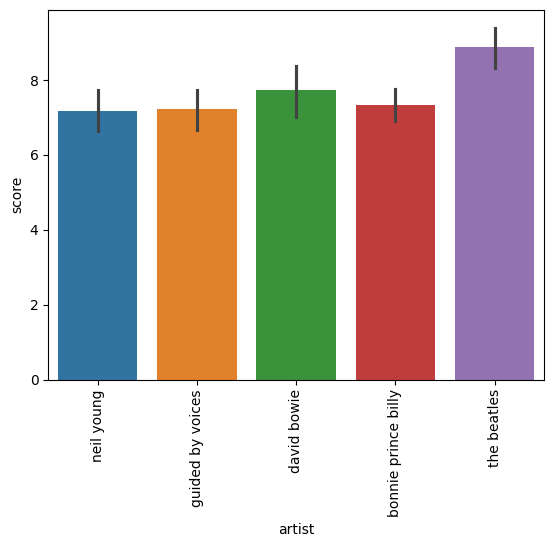

In [34]:
with SQLITEConnection(comd_artists_reviews) as gen_df:
    reviews_df = gen_df()

    reviews_df = get_artists_reviewed_multiple_times(reviews_df)

    ax = sns.barplot(
        data=reviews_df,
        x='artist',
        y='score',
        hue='artist'
    )

    ax.tick_params(axis='x', rotation=90)

# Artists Scores over time

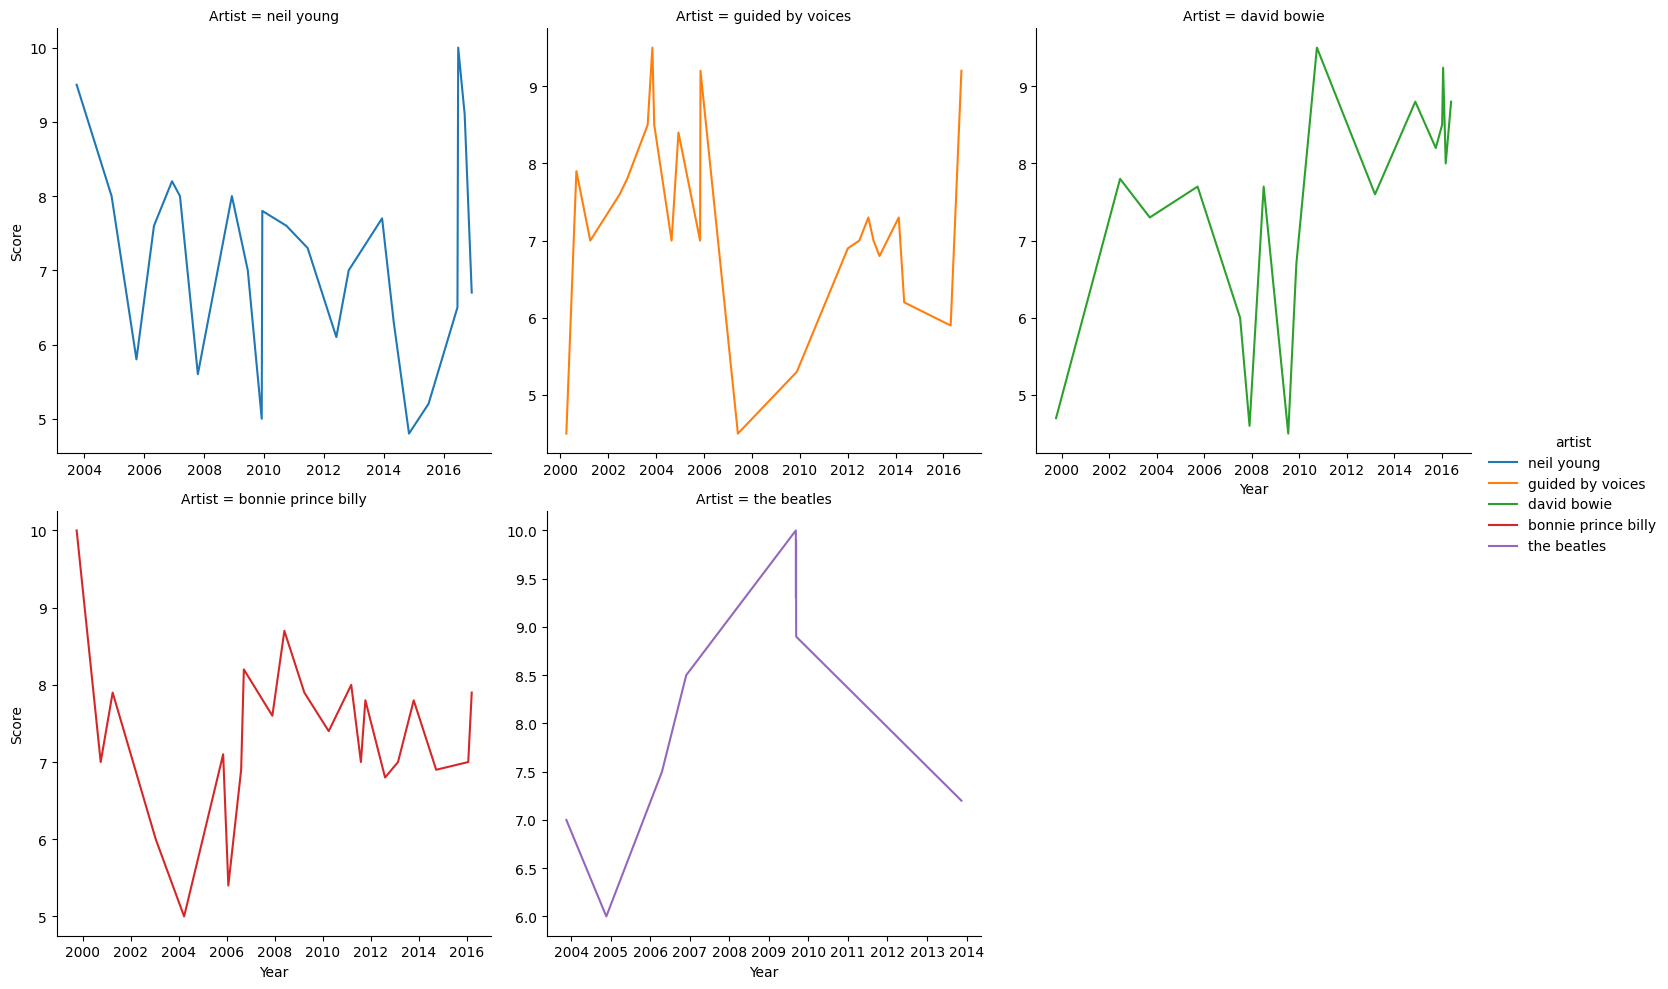

In [35]:
with SQLITEConnection(comd_artists_reviews) as gen_df:
    reviews_df = gen_df()

    reviews_df['formatted_pub_date'] = pd.to_datetime(reviews_df['pub_date'], format='%Y-%m-%d')

    reviews_df = get_artists_reviewed_multiple_times(reviews_df)

    # reviews_df.info()

    fg = sns.relplot(
        data=reviews_df,
        x='formatted_pub_date',
        y='score',
        hue='artist',
        col='artist',
        col_wrap=3,
        kind='line',
        errorbar=None,
        facet_kws={'sharex': False, 'sharey': False}
    )

    fg.set_titles('Artist = {col_name}')
    fg.set_xlabels('Year')
    fg.set_ylabels('Score')

# Genres

## Count of Reviews

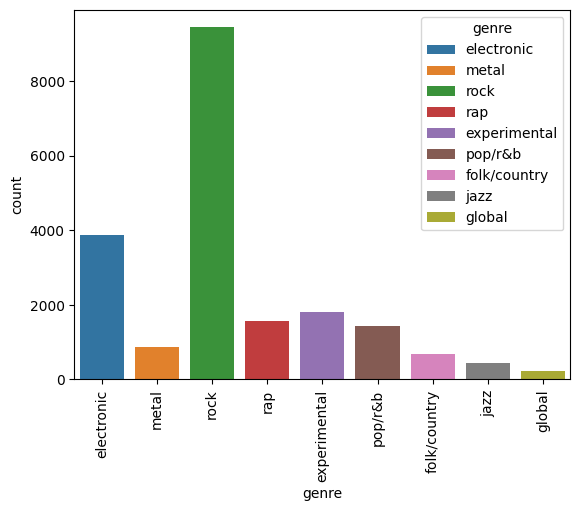

In [36]:
with SQLITEConnection(comd_genres_reviews) as gen_df:
    genres_joined_df = gen_df()

    # genres_joined_df.info()

    ax = sns.countplot(
        data=genres_joined_df,
        x='genre',
        hue='genre'
    )

    ax.tick_params(axis='x', rotation=90)

## Scores

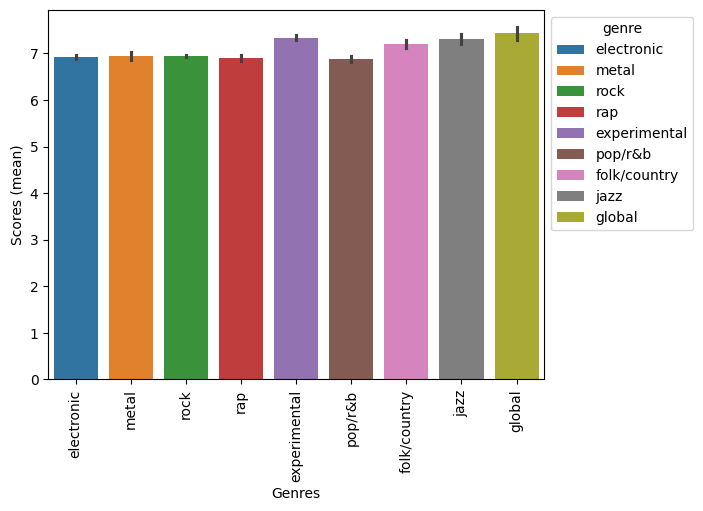

In [37]:
with SQLITEConnection(comd_genres_reviews) as gen_df:
    genres_joined_df = gen_df()

    # print(genres_joined_df['genre'].value_counts(ascending=False))

    genres_joined_ax = sns.barplot(
        data=genres_joined_df,
        y='score',
        x='genre',
        hue='genre'
    )

    sns.move_legend(genres_joined_ax, "upper left", bbox_to_anchor=(1, 1))

    genres_joined_ax.set_ylabel('Scores (mean)')
    genres_joined_ax.set_xlabel('Genres')

    genres_joined_ax.tick_params(axis='x', rotation=90)
    # genres_joined_df.info()

# Labels

## Count of Reviews

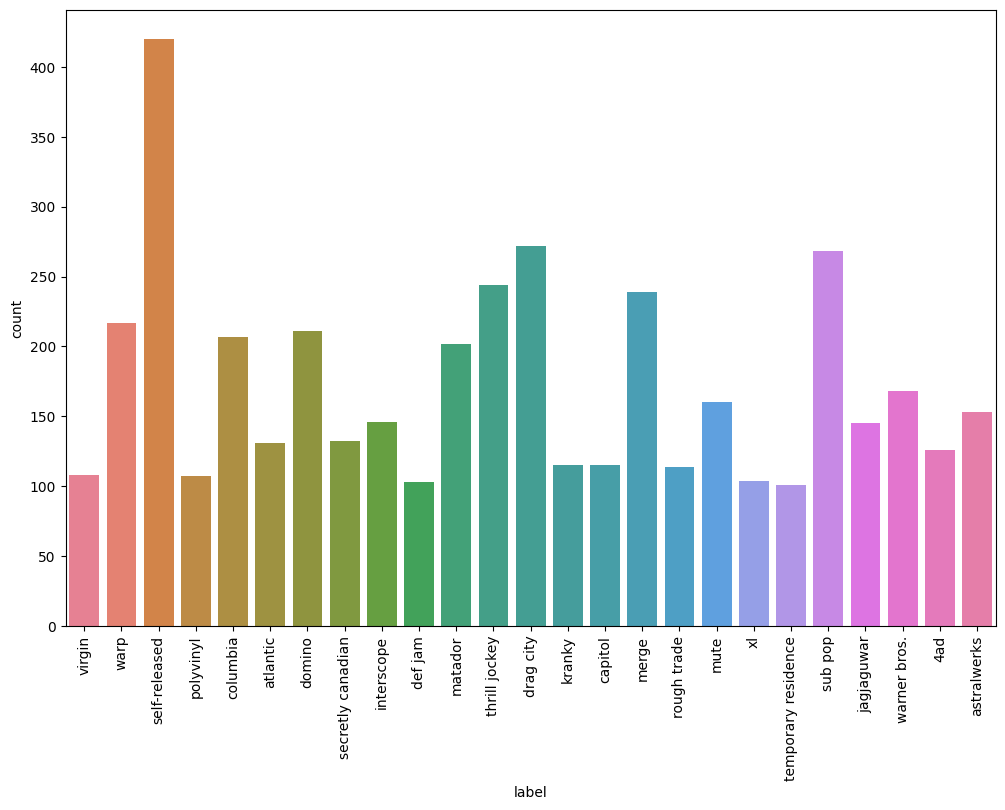

In [38]:
with SQLITEConnection(comd_labels_reviews) as gen_df:
    labels_reviews_df = gen_df()

    labels_reviews_df = labels_reviews_df.dropna(subset=['label'])
    
    # labels_reviews_df.info()

    labels_count_ser = labels_reviews_df['label'].value_counts(ascending=False)
    most_reviewed_labels = labels_count_ser[labels_count_ser > 100]

    most_reviewed_labels = labels_reviews_df[labels_reviews_df['label'].isin(most_reviewed_labels.index)]

    fig, ax = pyplot.subplots(figsize=(12, 8))

    labels_ax = sns.countplot(
        data=most_reviewed_labels,
        x='label',
        hue='label',
        ax=ax
    )

    labels_ax.tick_params(axis='x', rotation=90)

## Scores

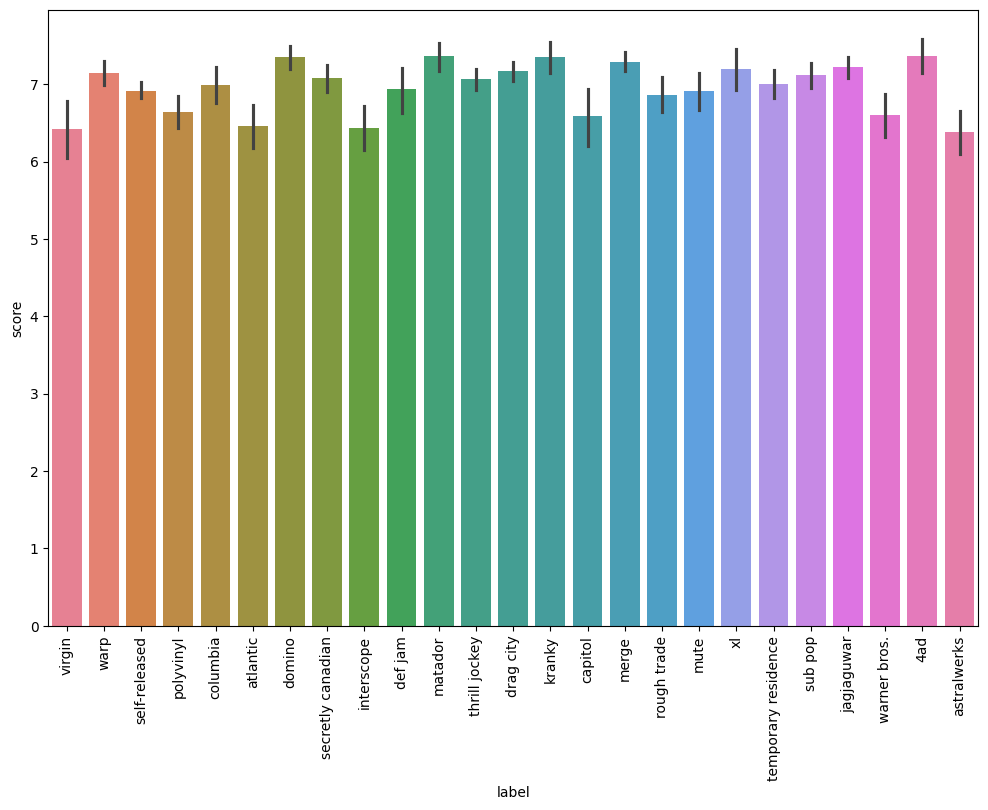

In [39]:
with SQLITEConnection(comd_labels_reviews) as gen_df:
    labels_reviews_df = gen_df()

    labels_reviews_df = labels_reviews_df.dropna(subset=['label'])
    
    # labels_reviews_df.info()

    labels_count_ser = labels_reviews_df['label'].value_counts(ascending=False)
    most_reviewed_labels = labels_count_ser[labels_count_ser > 100]

    most_reviewed_labels = labels_reviews_df[labels_reviews_df['label'].isin(most_reviewed_labels.index)]

    fig, ax = pyplot.subplots(figsize=(12, 8))

    labels_ax = sns.barplot(
        data=most_reviewed_labels,
        x='label',
        y='score',
        hue='label',
        ax=ax
    )

    labels_ax.tick_params(axis='x', rotation=90)

In [40]:
# with SQLITEConnection('SELECT * FROM reviews') as reviews_gen_df, SQLITEConnection('SELECT * FROM artists') as artists_gen_df:
#     reviews_df = reviews_gen_df()
#     artists_df = artists_gen_df()

#     joined_reviews_df = pd.merge(artists_df, reviews_df, how='inner', on='reviewid')

#     joined_reviews_df.info()